# Here is the Step2 about coincidence coding

In [1]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Simulated Data Generation

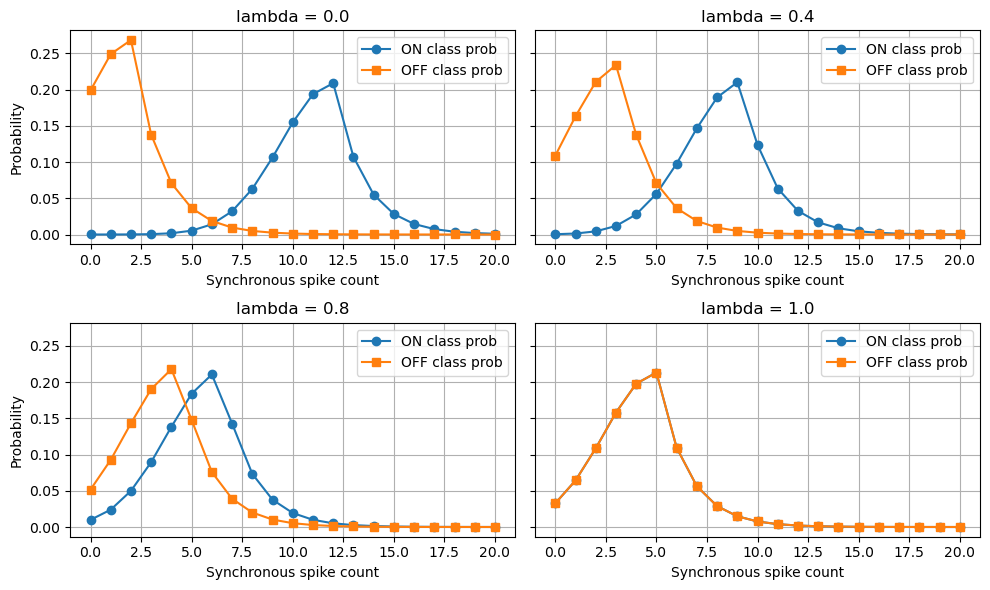

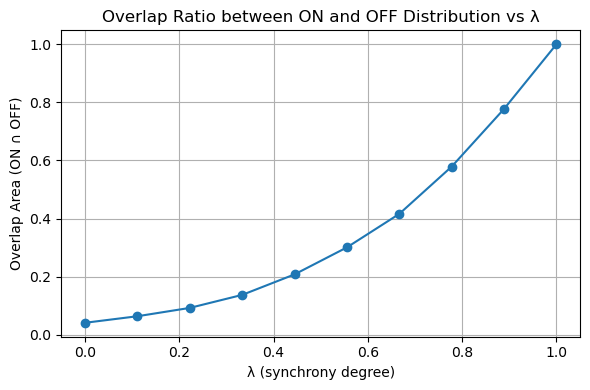

In [69]:
import numpy as np
import matplotlib.pyplot as plt

n_neurons = 20
sig = 2
scale_on = 3
scale_off = 3
n_timesteps = 100

def on_prob(k, peak):
    return np.exp(-0.3 * ((k - peak) / sig) ** 2) if k <= peak else np.exp(-2 * (k - peak) / scale_on)

def off_prob(k, peak):
    return np.exp(-0.3 * ((k - peak) / sig) ** 2) if k <= peak else np.exp(-2 * (k - peak) / scale_off)

def normalize_probs(prob_fn, max_k):
    raw = np.array([prob_fn(k) for k in range(max_k + 1)])
    return raw / raw.sum()

lambdas = [0.0, 0.4, 0.8, 1.0]
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
axs = axs.flatten()

for i, lam in enumerate(lambdas):
    on_mu = (1 - lam) * 12 + lam * 5
    off_mu = (1 - lam) * 2 + lam * 5

    on_probs = normalize_probs(lambda k: on_prob(k, on_mu), n_neurons)
    off_probs = normalize_probs(lambda k: off_prob(k, off_mu), n_neurons)

    axs[i].plot(on_probs, label="ON class prob", marker='o')
    axs[i].plot(off_probs, label="OFF class prob", marker='s')
    axs[i].set_title(f"lambda = {lam}")
    axs[i].set_xlabel("Synchronous spike count")
    axs[i].grid(True)
    if i % 2 == 0:
        axs[i].set_ylabel("Probability")
    axs[i].legend()

plt.tight_layout()
plt.show()

def compute_overlap(on_probs, off_probs):
    return np.sum(np.minimum(on_probs, off_probs))

# ==== lambda 扫描 ====
lambda_values = np.linspace(0, 1.0, 10)
overlaps = []

for lam in lambda_values:
    on_mu = (1 - lam) * 12 + lam * 5
    off_mu = (1 - lam) * 2 + lam * 5
    on_probs = normalize_probs(lambda k: on_prob(k, on_mu), n_neurons)
    off_probs = normalize_probs(lambda k: off_prob(k, off_mu), n_neurons)
    overlap = compute_overlap(on_probs, off_probs)
    overlaps.append(overlap)

# ==== 绘图 ====
plt.figure(figsize=(6, 4))
plt.plot(lambda_values, overlaps, marker='o')
plt.xlabel("λ (synchrony degree)")
plt.ylabel("Overlap Area (ON ∩ OFF)")
plt.title("Overlap Ratio between ON and OFF Distribution vs λ")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==== 参数 ====
n_neurons = 20
sig = 2
scale_on = 3
scale_off = 3

def on_prob(k, peak):
    return np.exp(-0.3 * ((k - peak) / sig) ** 2) if k <= peak else np.exp(-2 * (k - peak) / scale_on)

def off_prob(k, peak):
    return np.exp(-0.3 * ((k - peak) / sig) ** 2) if k <= peak else np.exp(-2 * (k - peak) / scale_off)

def normalize_probs(prob_fn, max_k):
    raw = np.array([prob_fn(k) for k in range(max_k + 1)])
    return raw / raw.sum()

def compute_overlap(on_probs, off_probs):
    return np.sum(np.minimum(on_probs, off_probs))

# ==== 穷举搜索 λ 值空间 ====
lambda_grid = np.linspace(0, 1.0, 1001)  # 扫描1001个点
overlap_dict = {}

target_overlaps = np.round(np.arange(0.1, 1.01, 0.1), 2)  # [0.1, 0.2, ..., 1.0]
found_overlap = {v: (None, float('inf')) for v in target_overlaps}

for lam in lambda_grid:
    on_mu = (1 - lam) * 12 + lam * 5
    off_mu = (1 - lam) * 2 + lam * 5
    on_probs = normalize_probs(lambda k: on_prob(k, on_mu), n_neurons)
    off_probs = normalize_probs(lambda k: off_prob(k, off_mu), n_neurons)
    overlap = compute_overlap(on_probs, off_probs)

    for target in target_overlaps:
        dist = abs(overlap - target)
        if dist < found_overlap[target][1]:
            found_overlap[target] = (lam, dist)

# ==== 构造映射表 ====
lambda_mapping = {0.0: 0.0}
for target, (lam, err) in found_overlap.items():
    lambda_mapping[round(target, 2)] = round(lam, 4)

# ==== 打印结果 ====
print("Target Overlap → Mapped Lambda")
for o, l in lambda_mapping.items():
    print(f"{o:.1f} → {l:.4f}")

# ==== 可选：保存为 .npy 文件 ====
#np.save("lambda_mapping.npy", lambda_mapping)


Target Overlap → Mapped Lambda
0.0 → 0.0000
0.1 → 0.2450
0.2 → 0.4350
0.3 → 0.5550
0.4 → 0.6520
0.5 → 0.7290
0.6 → 0.7910
0.7 → 0.8500
0.8 → 0.9000
0.9 → 0.9490
1.0 → 1.0000


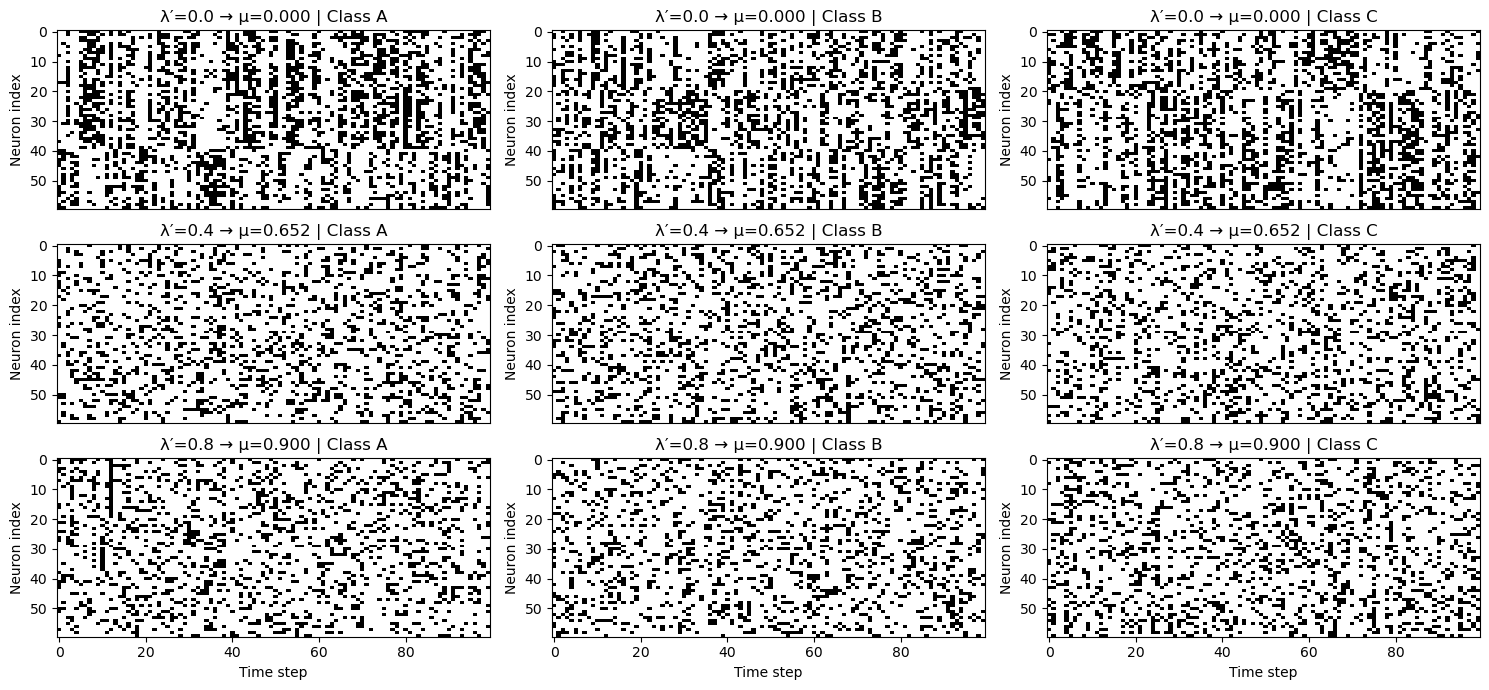

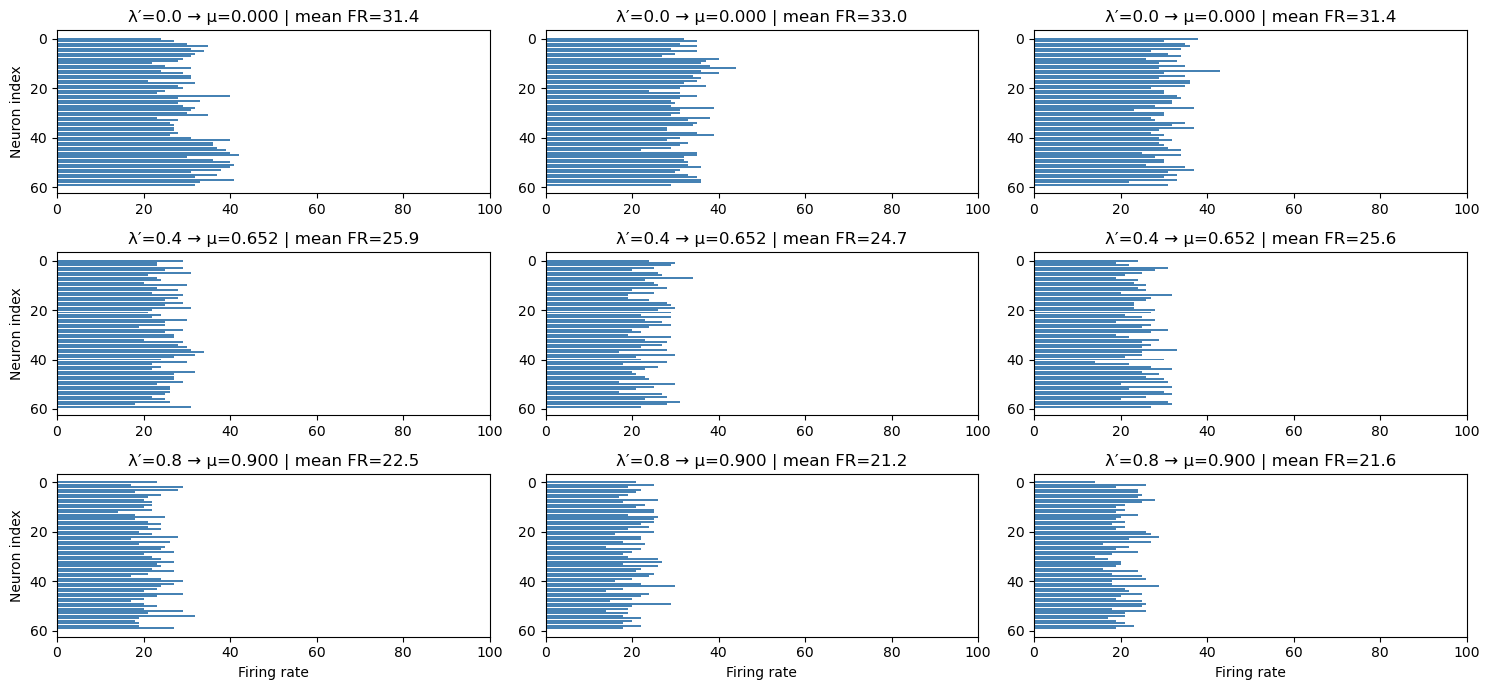

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# ==== 1. 定义 overlap → mu_lambda 映射 ====
lambda_mapping = {
    0.0: 0.0000,
    0.1: 0.2450,
    0.2: 0.4350,
    0.3: 0.5550,
    0.4: 0.6520,
    0.5: 0.7290,
    0.6: 0.7910,
    0.7: 0.8500,
    0.8: 0.9000,
    0.9: 0.9490,
    1.0: 1.0000
}

# ==== 2. 参数设置 ====
n_neurons = 60  # 3组，每组20个neuron
group_size = 20
n_timesteps = 100
sig = 2
scale_on = 3
scale_off = 3

def on_prob(k, peak):
    return np.exp(-0.3 * ((k - peak) / sig) ** 2) if k <= peak else np.exp(-2 * (k - peak) / scale_on)

def off_prob(k, peak):
    return np.exp(-0.3 * ((k - peak) / sig) ** 2) if k <= peak else np.exp(-2 * (k - peak) / scale_off)

def normalize_probs(prob_fn, max_k):
    raw = np.array([prob_fn(k) for k in range(max_k + 1)])
    return raw / raw.sum()

def generate_sample(lam, class_type):
    on_mu = (1 - lam) * 12 + lam * 5
    off_mu = (1 - lam) * 2 + lam * 5
    on_probs = normalize_probs(lambda k: on_prob(k, on_mu), group_size)
    off_probs = normalize_probs(lambda k: off_prob(k, off_mu), group_size)

    spikes = np.zeros((n_neurons, n_timesteps))
    group1 = np.arange(0, 20)
    group2 = np.arange(20, 40)
    group3 = np.arange(40, 60)

    current_state = np.random.rand() < 0.5

    for t in range(n_timesteps):
        if t > 0 and np.random.rand() < 0.5:
            current_state = not current_state

        if class_type == 'A':
            g1_dist = on_probs if current_state else off_probs
            g2_dist = g1_dist
            g3_dist = off_probs if current_state else on_probs
        elif class_type == 'B':
            g1_dist = on_probs if current_state else off_probs
            g3_dist = g1_dist
            g2_dist = off_probs if current_state else on_probs
        elif class_type == 'C':
            g2_dist = on_probs if current_state else off_probs
            g3_dist = g2_dist
            g1_dist = off_probs if current_state else on_probs

        for group_neurons, dist in zip([group1, group2, group3], [g1_dist, g2_dist, g3_dist]):
            k = np.random.choice(np.arange(group_size + 1), p=dist)
            if k > 0:
                active = np.random.choice(group_size, size=k, replace=False)
                spikes[group_neurons[active], t] = 1

    return spikes

# ==== 3. 线性 overlap λ′ 与 class 设置 ====
overlap_lambdas = [0.0, 0.4, 0.8]  # λ′
class_labels = ['A', 'B', 'C']

# ==== 4. 可视化 spike raster 图 ====
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(len(overlap_lambdas), len(class_labels))

for row, lam in enumerate(overlap_lambdas):
    true_lambda = lambda_mapping[round(lam, 1)]  # 查映射
    for col, label in enumerate(class_labels):
        spike = generate_sample(true_lambda, label)
        ax = plt.subplot(gs[row, col])
        ax.imshow(spike, aspect='auto', cmap='Greys', interpolation='nearest')
        ax.set_title(f"λ′={lam:.1f} → μ={true_lambda:.3f} | Class {label}")
        ax.set_ylabel("Neuron index")
        if row == len(overlap_lambdas) - 1:
            ax.set_xlabel("Time step")
        else:
            ax.set_xticks([])

plt.tight_layout()
plt.show()

# ==== 5. 可视化 firing rate 图 ====
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(len(overlap_lambdas), len(class_labels))

for row, lam in enumerate(overlap_lambdas):
    true_lambda = lambda_mapping[round(lam, 1)]
    for col, label in enumerate(class_labels):
        spike = generate_sample(true_lambda, label)
        fr = spike.sum(axis=1)
        ax = plt.subplot(gs[row, col])
        ax.barh(np.arange(n_neurons), fr, color='steelblue')
        ax.invert_yaxis()
        ax.set_xlim([0, n_timesteps])
        ax.set_title(f"λ′={lam:.1f} → μ={true_lambda:.3f} | mean FR={np.mean(fr):.1f}")
        if col == 0:
            ax.set_ylabel("Neuron index")
        if row == len(overlap_lambdas) - 1:
            ax.set_xlabel("Firing rate")

plt.tight_layout()
plt.show()


Generate dataset and save as .mat

In [77]:
import numpy as np
import scipy.io as io

# ==== 1. 定义 λ′ → μ 加权 lambda 的映射表 ====
lambda_mapping = {
    0.0: 0.0000,
    0.1: 0.2450,
    0.2: 0.4350,
    0.3: 0.5550,
    0.4: 0.6520,
    0.5: 0.7290,
    0.6: 0.7910,
    0.7: 0.8500,
    0.8: 0.9000,
    0.9: 0.9490,
    1.0: 1.0000
}

# ==== 2. 数据生成参数 ====
n_samples_per_class = 1000
lambda_prime_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
class_map = {'A': 0, 'B': 1, 'C': 2}

X_all = []
Y_all = []
lambda_all = []  # 仍然存储 λ′，用于训练时标注

# ==== 3. 主生成循环 ====
for lam_prime in lambda_prime_values:
    lam_true = lambda_mapping[round(lam_prime, 1)]  # 映射为 mu-weighted λ
    print(f"Generating for λ′ = {lam_prime:.1f} → μ = {lam_true:.4f}")
    for cls in ['A', 'B', 'C']:
        for _ in range(n_samples_per_class):
            spike = generate_sample(lam_true, cls)
            X_all.append(spike)
            Y_all.append(class_map[cls])
            lambda_all.append(lam_prime)  # 这里保存的是 λ′

# ==== 4. 保存为 .mat 文件 ====
X_all = np.array(X_all, dtype=np.uint8)        # shape = (N, 60, 100)
Y_all = np.array(Y_all, dtype=np.int32)        # shape = (N,)
lambda_all = np.array(lambda_all, dtype=float) # shape = (N,)

print(f"Final shape: X={X_all.shape}, Y={Y_all.shape}, lambda={lambda_all.shape}")

io.savemat("coin_data.mat", {
    'X': X_all,
    'Y': Y_all,
    'lambda': lambda_all  # λ′
})

print("Saved to coin_data.mat")


Generating for λ′ = 0.0 → μ = 0.0000
Generating for λ′ = 0.1 → μ = 0.2450
Generating for λ′ = 0.2 → μ = 0.4350
Generating for λ′ = 0.3 → μ = 0.5550
Generating for λ′ = 0.4 → μ = 0.6520
Generating for λ′ = 0.5 → μ = 0.7290
Generating for λ′ = 0.6 → μ = 0.7910
Generating for λ′ = 0.7 → μ = 0.8500
Generating for λ′ = 0.8 → μ = 0.9000
Generating for λ′ = 0.9 → μ = 0.9490
Generating for λ′ = 1.0 → μ = 1.0000
Final shape: X=(33000, 60, 100), Y=(33000,), lambda=(33000,)
Saved to coin_data.mat


X shape = (33000, 60, 100), Y shape = (33000,)


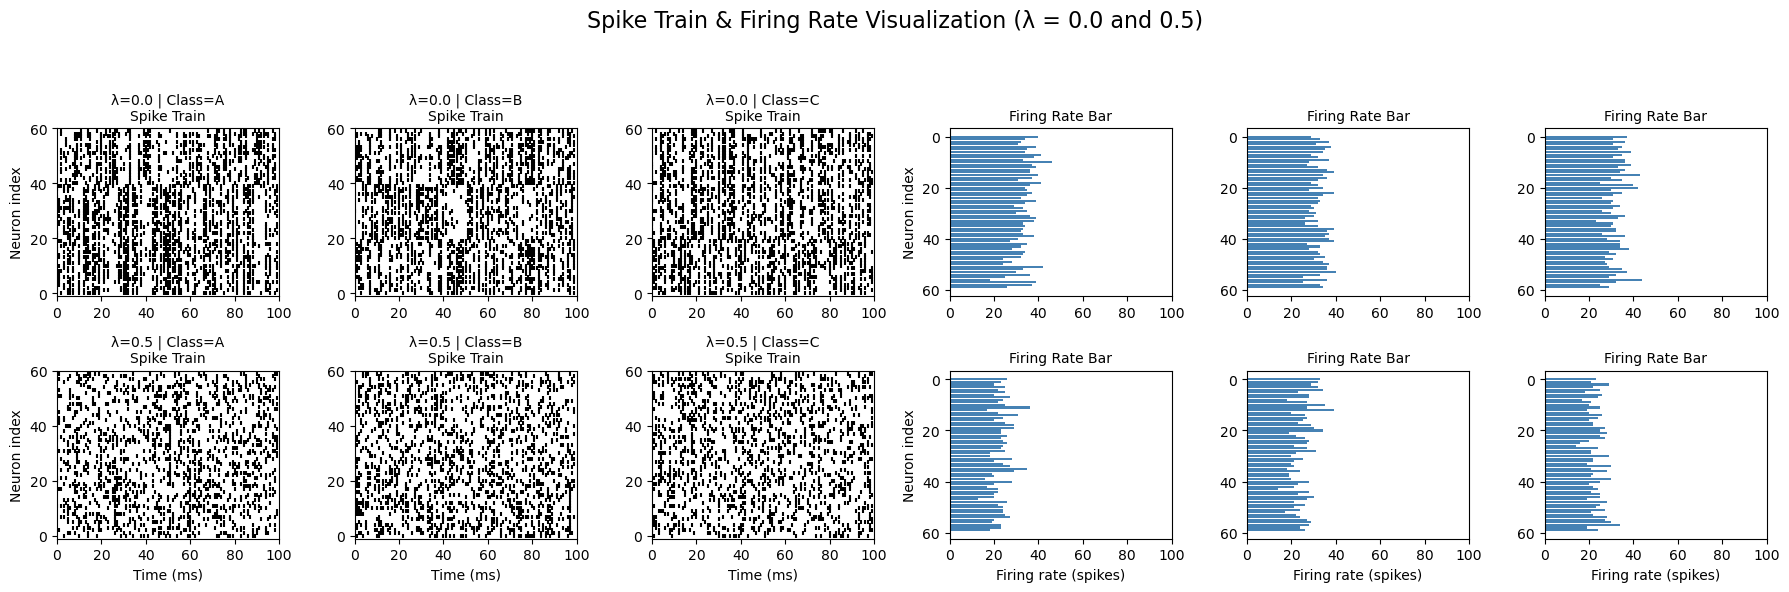

In [79]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

# 加载你自定义的 A/B/C 数据集
data = io.loadmat('coin_data.mat')  # 👈 确保文件名正确
X = data['X']            # shape: (N, num_neurons, T)
Y = data['Y'].ravel()    # shape: (N,)
lambdas = data['lambda'].ravel()  # shape: (N,)

N, num_neurons, T = X.shape
print(f"X shape = {X.shape}, Y shape = {Y.shape}")

selected_lambdas = [0.0, 0.5]
class_labels = [0, 1, 2]  # 对应 A/B/C
label_map = {0: 'A', 1: 'B', 2: 'C'}

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 6), sharex=False, sharey=False)
fig.suptitle("Spike Train & Firing Rate Visualization (λ = 0.0 and 0.5)", fontsize=16)

for row, lam in enumerate(selected_lambdas):
    for col, cls in enumerate(class_labels):

        indices = np.where((np.isclose(lambdas, lam)) & (Y == cls))[0]
        if len(indices) == 0:
            print(f"No sample found for lambda={lam} and class={cls}")
            continue
        sample_idx = np.random.choice(indices)
        spike_mat = X[sample_idx]

        # (A) Spike raster plot
        ax_spike = axes[row, col]
        for neuron_idx in range(num_neurons):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax_spike.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                             s=5, marker='|', color='k')
        ax_spike.set_title(f"λ={lam:.1f} | Class={label_map[cls]}\nSpike Train", fontsize=10)
        ax_spike.set_xlim([0, T])
        ax_spike.set_ylim([-1, num_neurons])
        if row == 1:
            ax_spike.set_xlabel("Time (ms)")
        if col == 0:
            ax_spike.set_ylabel("Neuron index")

        # (B) Firing rate bar plot
        ax_fr = axes[row, col + 3]
        fr_each_neuron = spike_mat.sum(axis=1)
        y_positions = np.arange(num_neurons)
        ax_fr.barh(y_positions, fr_each_neuron, color='steelblue')
        ax_fr.invert_yaxis()
        ax_fr.set_xlim([0, T])
        ax_fr.set_title("Firing Rate Bar", fontsize=10)
        if row == 1:
            ax_fr.set_xlabel("Firing rate (spikes)")
        if col == 0:
            ax_fr.set_ylabel("Neuron index")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [80]:
import numpy as np
import scipy.io as io

# ===== Load data =====
data = io.loadmat('coin_data.mat')
X = data['X']                      # shape: (N, num_neurons, T)
Y = data['Y'].ravel()              # shape: (N,)
lambdas = data['lambda'].ravel()   # shape: (N,)

# ===== Compute average firing rate per class =====
num_classes = len(np.unique(Y))
T = X.shape[2]  # time steps

print("Average Firing Rate per Class (Total spikes per neuron over time window):\n")

for cls in range(num_classes):
    indices = np.where(Y == cls)[0]
    X_cls = X[indices]  # shape: (N_cls, num_neurons, T)

    firing_rates = X_cls.sum(axis=2)  # Sum over time → shape: (N_cls, num_neurons)
    mean_firing_rate = firing_rates.mean()  # scalar: overall average for this class

    print(f"Class {cls} → Avg Firing Rate = {mean_firing_rate:.2f} spikes per neuron")


Average Firing Rate per Class (Total spikes per neuron over time window):

Class 0 → Avg Firing Rate = 24.77 spikes per neuron
Class 1 → Avg Firing Rate = 24.78 spikes per neuron
Class 2 → Avg Firing Rate = 24.77 spikes per neuron


## Split Dataset and Define Help Function


=== lambda = 0.0 ===


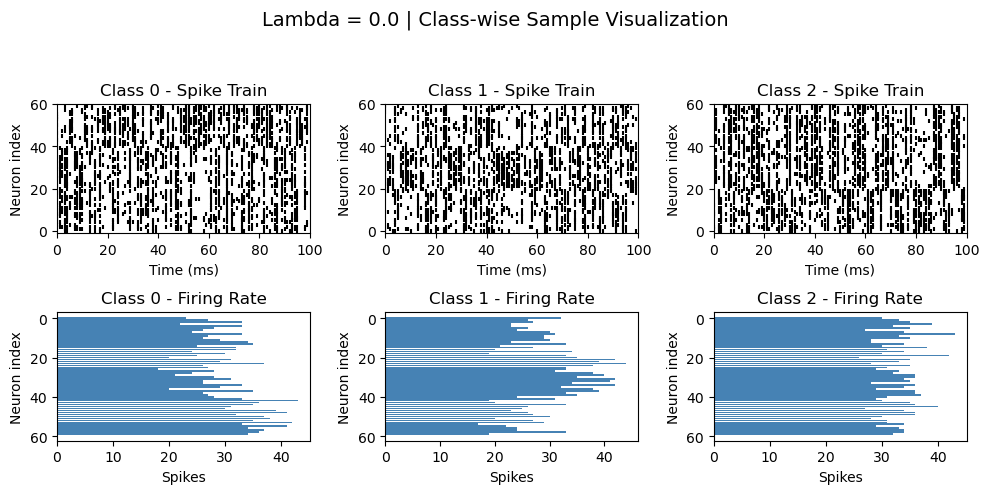


=== lambda = 0.8 ===


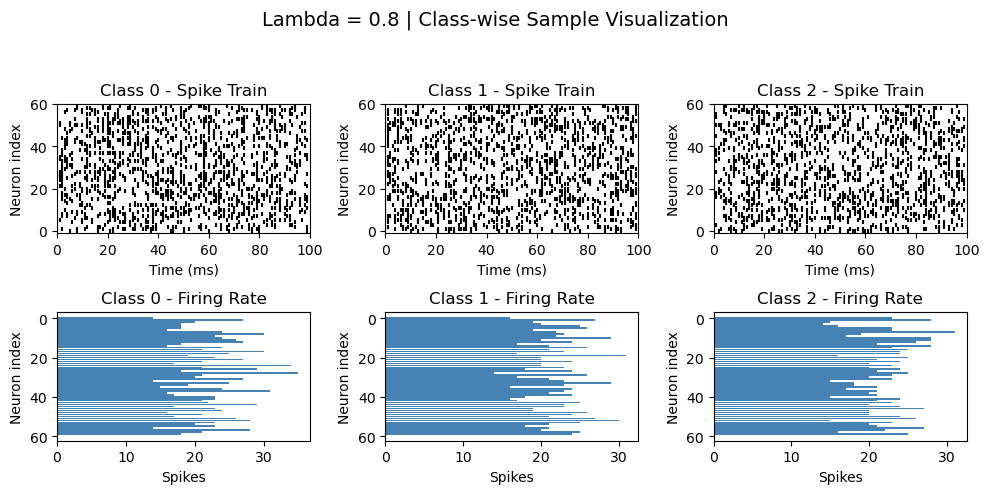

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import torch

data = io.loadmat('coin_data.mat')
X_all = data['X']  # shape: (N, num_neurons, T)
Y_all = data['Y'].ravel()
lambda_all = data['lambda'].ravel()

num_neurons = X_all.shape[1]
num_classes = 3
lambda_list = np.unique(lambda_all)

def get_split_by_lambda(lam, train_ratio=0.6, val_ratio=0.15, test_ratio=0.15, seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if seed is not None:
        np.random.seed(seed)

    X_train, Y_train = [], []
    X_val, Y_val = [], []
    X_test, Y_test = [], []

    for cls in range(num_classes):
        indices = np.where((np.isclose(lambda_all, lam)) & (Y_all == cls))[0]
        np.random.shuffle(indices)
        n = len(indices)
        if n == 0:
            print(f"lambda={lam}, class={cls} has no samples!")
            continue

        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        n_test = n - n_train - n_val

        train_idx = indices[:n_train]
        val_idx   = indices[n_train:n_train + n_val]
        test_idx  = indices[n_train + n_val:]

        X_train.extend(X_all[train_idx])
        Y_train.extend(Y_all[train_idx])
        X_val.extend(X_all[val_idx])
        Y_val.extend(Y_all[val_idx])
        X_test.extend(X_all[test_idx])
        Y_test.extend(Y_all[test_idx])

    return (np.array(X_train), np.array(Y_train),
            np.array(X_val), np.array(Y_val),
            np.array(X_test), np.array(Y_test))

def get_batches(X_data, Y_data, batch_size=32, verbose=False, max_num_batches=None, shuffle=True, drop_last=False):
    N, num_neurons, num_time_points = X_data.shape
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    total_batches = N // batch_size
    if not drop_last and N % batch_size != 0:
        total_batches += 1

    if max_num_batches is not None:
        total_batches = min(total_batches, max_num_batches)

    if verbose:
        print(f"batch_size = {batch_size}")
        print(f"num_time_points = {num_time_points}")
        print(f"num_batches = {total_batches}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024**3):.4f} GB")

    for b in range(total_batches):
        start_idx = b * batch_size
        end_idx = min(start_idx + batch_size, N)
        batch_idx = indices[start_idx:end_idx]
        x_out = torch.tensor(X_data[batch_idx], dtype=torch.float32)
        y_out = torch.tensor(Y_data[batch_idx], dtype=torch.long)
        yield x_out, y_out

lambda_values = [0.0, 0.8]

for lam in lambda_values:
    print(f"\n=== lambda = {lam} ===")
    
    X_lam, Y_lam,_,_,_,_ = get_split_by_lambda(lam)
    T = X_lam.shape[2]

    for batch_x, batch_y in get_batches(X_lam, Y_lam, batch_size=32, max_num_batches=1, shuffle=True):
        break 

    batch_x = batch_x.numpy()
    batch_y = batch_y.numpy()

    selected_samples = []
    for cls in range(num_classes):
        cls_indices = np.where(batch_y == cls)[0]
        if len(cls_indices) > 0:
            selected_idx = np.random.choice(cls_indices)
            selected_samples.append((batch_x[selected_idx], cls))
        else:
            print(f"lambda={lam}, class={cls} has no samples!")

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
    fig.suptitle(f"Lambda = {lam} | Class-wise Sample Visualization", fontsize=14)

    for col, (spike_mat, cls_label) in enumerate(selected_samples):
        # spike raster 
        ax_raster = axes[0, col]
        for neuron_idx in range(num_neurons):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax_raster.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                              s=5, marker='|', color='black')
        ax_raster.set_title(f"Class {cls_label} - Spike Train")
        ax_raster.set_xlim([0, T])
        ax_raster.set_ylim([-1, num_neurons])
        ax_raster.set_xlabel("Time (ms)")
        ax_raster.set_ylabel("Neuron index")

        # firing rate bar 
        ax_bar = axes[1, col]
        firing_rates = spike_mat.sum(axis=1)
        ax_bar.barh(np.arange(num_neurons), firing_rates, color='steelblue')
        ax_bar.invert_yaxis()
        ax_bar.set_title(f"Class {cls_label} - Firing Rate")
        ax_bar.set_xlabel("Spikes")
        ax_bar.set_ylabel("Neuron index")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


## Build the Spiking Neural Network Model (SNN)

In [153]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

In [154]:
class SNNLayer(nn.Module):
  def __init__(self, n_in, n_out, spiking=True, **params):
    super(SNNLayer, self).__init__()
    self.n_in = n_in
    self.n_out = n_out
    self.w = nn.Parameter(torch.ones((n_in, n_out)))
    self.spiking = spiking
    self.params = dict(
        tau = 20*ms,
        alpha = None,
        dt = 1*ms,
        )
    self.params.update(**params)

  def forward(self, x):
    device = x.device  
    batch_size, num_neurons, num_time_points = x.shape
    assert num_neurons == self.n_in

    v = torch.zeros((batch_size, self.n_out), device=device)
    s = torch.zeros((batch_size, self.n_out), device=device)

    if self.params['alpha'] is not None:
      alpha = self.params['alpha']
    else:
      alpha = np.exp(-self.params['dt'] / self.params['tau'])
    h = torch.einsum('bit,ij->bjt', (x, self.w.to(device))) 

    if self.spiking:
      rec = [s]
    else:
      rec = [v]
    for t in range(num_time_points - 1):
      new_v = (v * alpha + h[:, :, t])
      if self.spiking:
        new_v = new_v * (1 - s)
        s = surrogate_heaviside(v - 1)
      v = new_v
      if self.spiking:
        rec.append(s)
      else:
        rec.append(v)
    y = torch.stack(rec, dim=2)
    return y

class MultilayerSNN(nn.Module):
    def __init__(self, layer_sizes, params):
        super(MultilayerSNN, self).__init__()
        assert layer_sizes[0] == num_neurons and layer_sizes[-1] == num_classes 
        assert len(layer_sizes) - 1 == len(params)

        self.layer_sizes = layer_sizes
        self.params = params
        self.num_layers = len(layer_sizes) - 1

        self.networks = nn.ModuleList()
        for n_in, n_out, p in zip(layer_sizes[:-1], layer_sizes[1:], params):
            net = SNNLayer(n_in, n_out, **p)
            nn.init.uniform_(net.w, *p['w_init'])
            self.networks.append(net)

    def forward(self, x, record=False):
        rec = []
        for net in self.networks:
            x = net(x)
            if record:
                rec.append(x)
        return (x, rec) if record else x

In [164]:
import torch.nn.functional as F
num_classes = 3

def evaluate_network(net, X_val, Y_val, batch_size=32):
    losses = []
    null_losses = []
    with torch.no_grad():
        for x, y in get_batches(X_val, Y_val, batch_size=batch_size, shuffle=False):
            y_out = net(x)
            y_out_final = y_out[:, :, -1]
            loss = F.cross_entropy(y_out_final, y.long())
            null_loss = F.cross_entropy(torch.zeros_like(y_out_final), y.long())
            losses.append(loss.item())
            null_losses.append(null_loss.item())
    return np.mean(losses), np.mean(null_losses)

def train_model(f, X_train, Y_train, X_val, Y_val,
                num_epochs=30, batch_size=32, max_num_batches=40, 
                lr=0.001, hidden_units=100, device='cuda', seed=42,
                early_stop_patience=50):

    print(f"\n=== Training model with f={f}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    net = MultilayerSNN((num_neurons, hidden_units, num_classes),
                        [dict(tau=50*ms, w_init=(-0.5, 0.7)),
                         dict(tau=500*ms, spiking=False, w_init=(-0.01, 0.01))]).to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None
    early_stop_counter = 0  # 初始化早停计数器

    num_train_samples = X_train.shape[0]
    total_batches = num_epochs * (min(num_train_samples // batch_size, max_num_batches) if max_num_batches else num_train_samples // batch_size)

    with tqdm(total=total_batches) as pbar:
        last_epoch_loss = val_loss = null_val_loss = None
        for epoch in range(num_epochs):
            local_loss = []
            for x, y in get_batches(X_train, Y_train, batch_size=batch_size, max_num_batches=max_num_batches, shuffle=True,verbose=(epoch==0)):

                x, y = x.to(device), y.to(device) # move data to device
                y_out = net(x)
                y_out_final = y_out[:, :, -1]
                loss = F.cross_entropy(y_out_final, y.long())
                local_loss.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(1)
                pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)

            last_epoch_loss = np.mean(local_loss)
            val_loss, null_val_loss = evaluate_network(net, X_val, Y_val, batch_size=batch_size)

            # 早停机制
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()
                early_stop_counter = 0  # 重置计数器
            else:
                early_stop_counter += 1
                if early_stop_counter >= early_stop_patience:
                    print(f"Early stopping triggered at epoch {epoch} (val_loss has not improved for {early_stop_patience} epochs).")
                    break

            pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
            loss_hist.append(last_epoch_loss)
            val_loss_hist.append(val_loss)

    # 可视化损失曲线
    plt.figure()
    plt.semilogy(loss_hist, label='Training loss')
    plt.semilogy(val_loss_hist, label='Validation loss')
    plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
    plt.xlabel('Epoch')
    plt.ylabel('CrossEntropy')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net, X_test, Y_test, batch_size=batch_size)
    print(f"test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss


def test_accuracy(net, X_test, Y_test, batch_size=30):
    total, correct = 0, 0
    with torch.no_grad():
        for x, y in get_batches(X_test, Y_test, batch_size=batch_size, shuffle=False, drop_last=False):
            preds = torch.argmax(net(x)[:, :, -1], dim=1)
            correct += (preds == y).sum().item()
            total += y.shape[0]
    return correct / total if total > 0 else 0.0

def plot_predictions(net, X_test, Y_test, batch_size=8, max_num_batches=1):
    plt.figure(figsize=(16, 6))
    with torch.no_grad():
        x, y = next(get_batches(X_test, Y_test, batch_size=batch_size))
        y_out = net(x)
        loss = F.cross_entropy(y_out[:, :, -1], y.long())
        T_show = x.shape[2]
        for b in range(min(batch_size, 8)):
            plt.subplot(2, 4, b + 1)
            plt.axhline(y[b].item(), color='k', linestyle='--', label='True label')
            for c in range(num_classes):
                class_curve = y_out[b, c, :].cpu().numpy()
                plt.plot(class_curve, label=f'logit class{c}')
            plt.ylim(-5, 5)
            plt.title(f"Sample {b}, True={y[b].item()},Loss={loss.item():.2f}")
            plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


def test_and_visualize_model(net, X_test, Y_test, batch_size=128, max_num_batches=1):
    acc = test_accuracy(net, X_test, Y_test, batch_size=batch_size)
    print(f"Test Accuracy = {acc:.2%}")
    #plot_predictions(net, X_test, Y_test, batch_size=batch_size, max_num_batches=max_num_batches)



### Training model for lambda = 0.0 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.0, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB


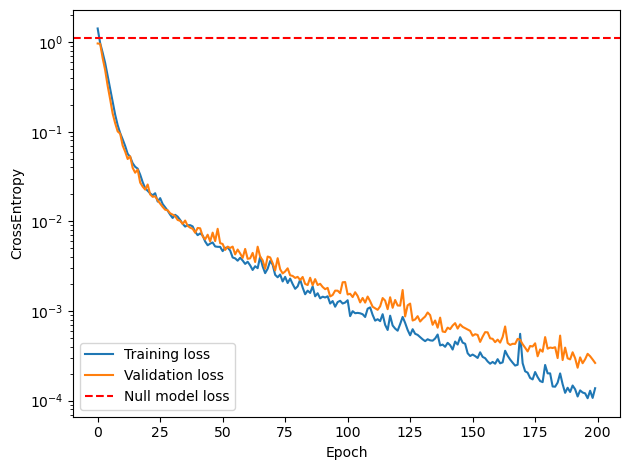

Loaded best model with val_loss=0.0002
test_loss=0.0004, null_test_loss=1.0986
Saved model: coin_f00.pt
Evaluating on test set...
Test Accuracy = 100.00%


In [85]:
lambda_values = [0.0]

for lam in lambda_values:
    print(f"\n### Training model for lambda = {lam} ###")

    X_train, Y_train, X_val, Y_val, X_test, Y_test = get_split_by_lambda(lam)


    print(f"X_train shape: {X_train.shape}")  # (N_train, num_neurons, T)
    print(f"Y_train shape: {Y_train.shape}")  # (N_train,)
    print(f"Unique labels in Y_train: {np.unique(Y_train)}")

    var_name = f"net_{int(lam * 10):02d}" 
    net, val_loss = train_model(
    f=lam,
    X_train=X_train,
    Y_train=Y_train,
    X_val=X_val,
    Y_val=Y_val,
    num_epochs=200
    )

    globals()[var_name] = net

    model_path = f"coin_f{int(lam * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    print("Evaluating on test set...")
    test_and_visualize_model(net, X_test, Y_test)


### Training model for lambda = 0.1 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.1, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB


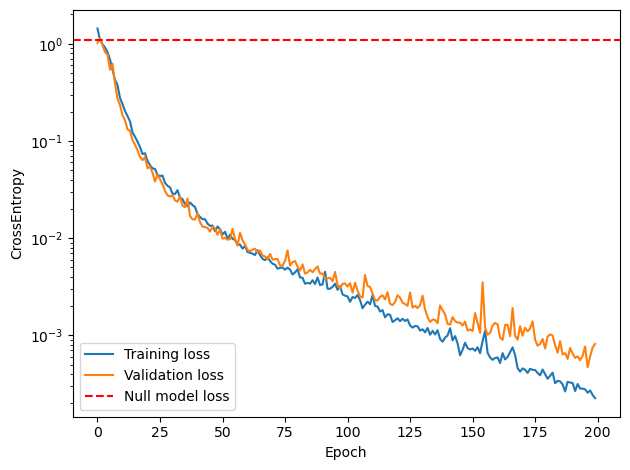

Loaded best model with val_loss=0.0005
test_loss=0.0019, null_test_loss=1.0986
Saved model: coin_f01.pt
Evaluating on test set...
Test Accuracy = 99.87%

### Training model for lambda = 0.2 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.2, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB


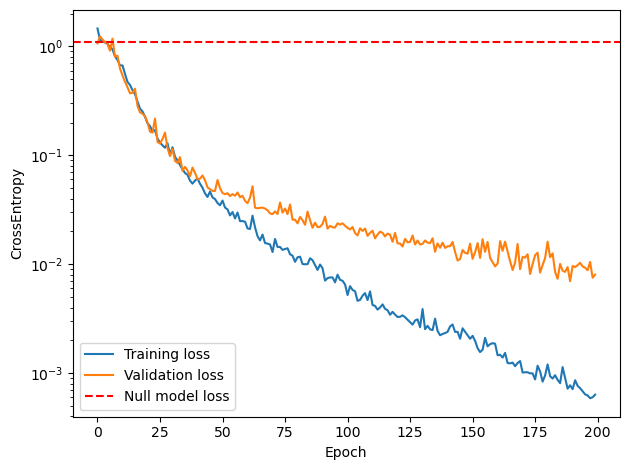

Loaded best model with val_loss=0.0070
test_loss=0.0080, null_test_loss=1.0986
Saved model: coin_f02.pt
Evaluating on test set...
Test Accuracy = 99.73%

### Training model for lambda = 0.3 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.3, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB


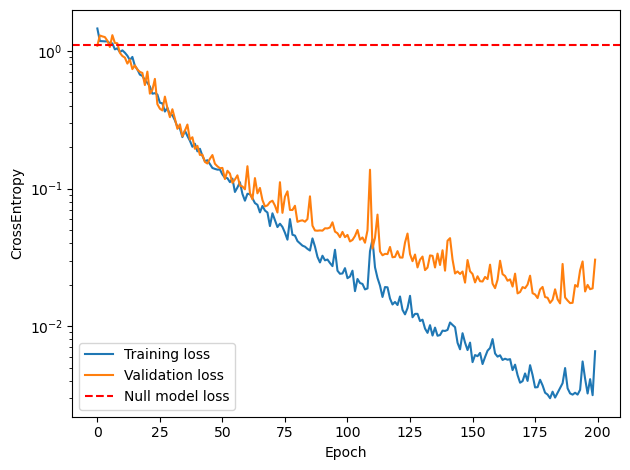

Loaded best model with val_loss=0.0146
test_loss=0.0438, null_test_loss=1.0986
Saved model: coin_f03.pt
Evaluating on test set...
Test Accuracy = 98.53%

### Training model for lambda = 0.4 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.4, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB


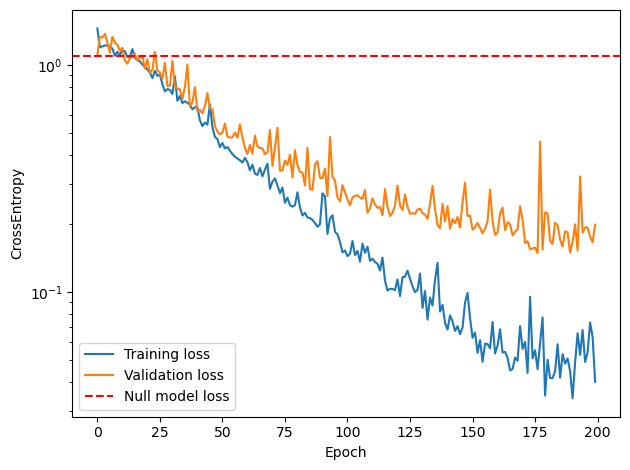

Loaded best model with val_loss=0.1485
test_loss=0.1992, null_test_loss=1.0986
Saved model: coin_f04.pt
Evaluating on test set...
Test Accuracy = 92.13%

### Training model for lambda = 0.5 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.5, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB


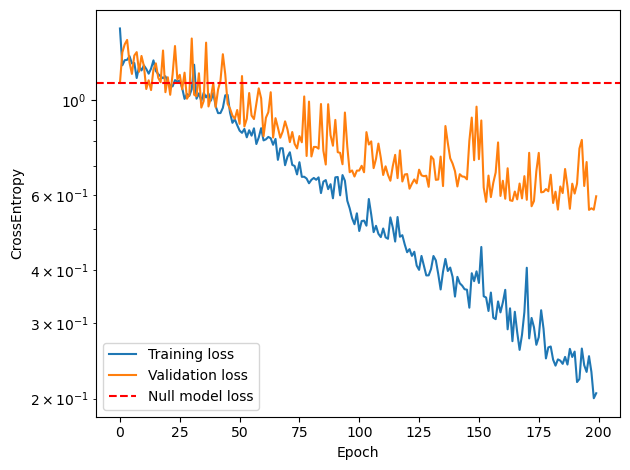

Loaded best model with val_loss=0.5532
test_loss=0.6431, null_test_loss=1.0986
Saved model: coin_f05.pt
Evaluating on test set...
Test Accuracy = 72.40%

### Training model for lambda = 0.6 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.6, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB
Early stopping triggered at epoch 136 (val_loss has not improved for 50 epochs).


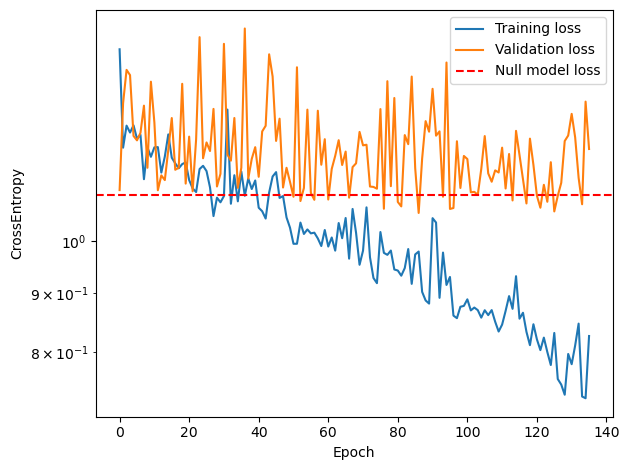

Loaded best model with val_loss=1.0587
test_loss=1.3758, null_test_loss=1.0986
Saved model: coin_f06.pt
Evaluating on test set...
Test Accuracy = 39.20%

### Training model for lambda = 0.7 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.7, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB
Early stopping triggered at epoch 61 (val_loss has not improved for 50 epochs).


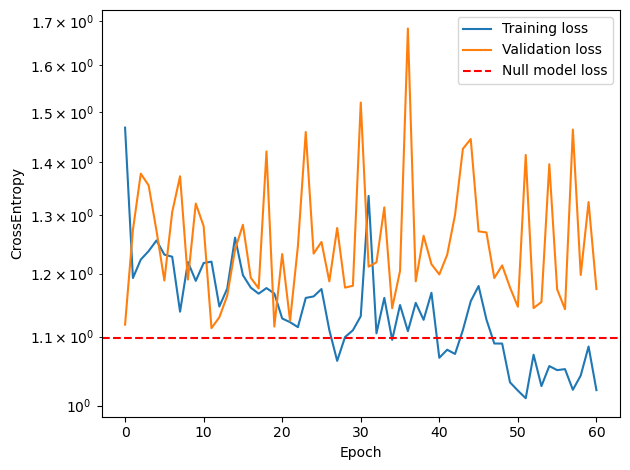

Loaded best model with val_loss=1.1129
test_loss=1.1656, null_test_loss=1.0986
Saved model: coin_f07.pt
Evaluating on test set...
Test Accuracy = 36.80%

### Training model for lambda = 0.8 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.8, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB
Early stopping triggered at epoch 50 (val_loss has not improved for 50 epochs).


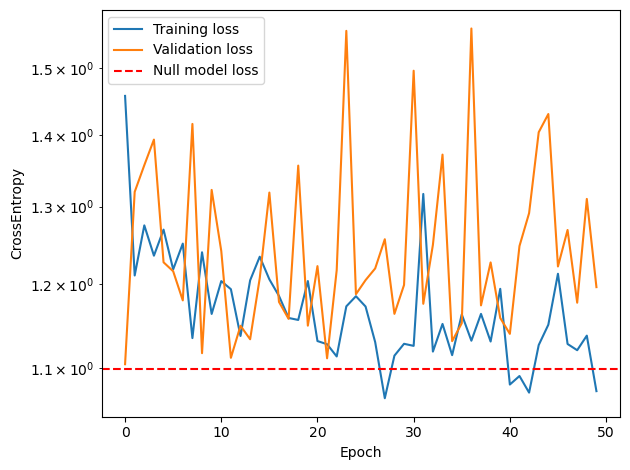

Loaded best model with val_loss=1.1044
test_loss=1.1431, null_test_loss=1.0986
Saved model: coin_f08.pt
Evaluating on test set...
Test Accuracy = 36.13%

### Training model for lambda = 0.9 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.9, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB
Early stopping triggered at epoch 50 (val_loss has not improved for 50 epochs).


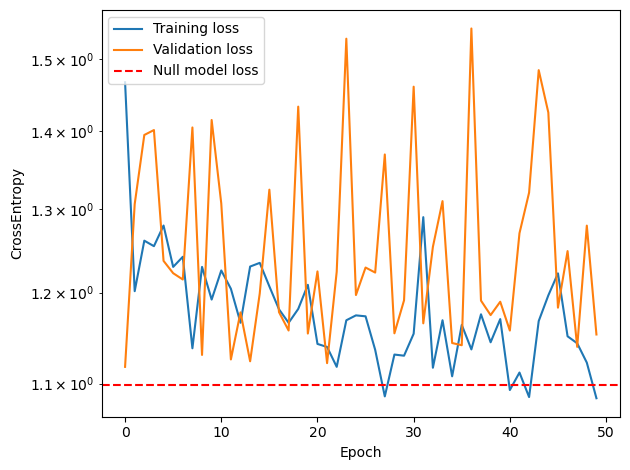

Loaded best model with val_loss=1.1178
test_loss=1.1458, null_test_loss=1.0986
Saved model: coin_f09.pt
Evaluating on test set...
Test Accuracy = 34.40%


In [168]:
lambda_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for lam in lambda_values:
    print(f"\n### Training model for lambda = {lam} ###")

    X_train, Y_train, X_val, Y_val, X_test, Y_test = get_split_by_lambda(lam)


    print(f"X_train shape: {X_train.shape}")  # (N_train, num_neurons, T)
    print(f"Y_train shape: {Y_train.shape}")  # (N_train,)
    print(f"Unique labels in Y_train: {np.unique(Y_train)}")

    var_name = f"net_{int(lam * 10):02d}" 
    net, val_loss = train_model(
    f=lam,
    X_train=X_train,
    Y_train=Y_train,
    X_val=X_val,
    Y_val=Y_val,
    num_epochs=200
    )

    globals()[var_name] = net

    model_path = f"coin_f{int(lam * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    print("Evaluating on test set...")
    test_and_visualize_model(net, X_test, Y_test)


### Training model for lambda = 1.0 ###
X_train shape: (1800, 60, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=1.0, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/8000 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0014 GB
Early stopping triggered at epoch 71 (val_loss has not improved for 50 epochs).


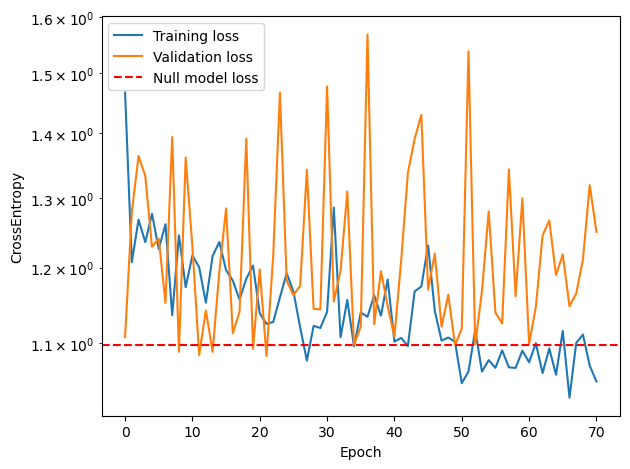

Loaded best model with val_loss=1.0843
test_loss=1.2288, null_test_loss=1.0986
Saved model: coin_f10.pt
Evaluating on test set...
Test Accuracy = 33.60%


In [165]:
lambda_values = [1.0]

for lam in lambda_values:
    print(f"\n### Training model for lambda = {lam} ###")

    X_train, Y_train, X_val, Y_val, X_test, Y_test = get_split_by_lambda(lam)


    print(f"X_train shape: {X_train.shape}")  # (N_train, num_neurons, T)
    print(f"Y_train shape: {Y_train.shape}")  # (N_train,)
    print(f"Unique labels in Y_train: {np.unique(Y_train)}")

    var_name = f"net_{int(lam * 10):02d}" 
    net, val_loss = train_model(
    f=lam,
    X_train=X_train,
    Y_train=Y_train,
    X_val=X_val,
    Y_val=Y_val,
    num_epochs=200
    )

    globals()[var_name] = net

    model_path = f"coin_f{int(lam * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    print("Evaluating on test set...")
    test_and_visualize_model(net, X_test, Y_test)

## Evaluation

Using device: cuda

=== Loading model coin_f00.pt and testing for λ = 0.0 ===
λ=0.0, Mean Acc=100.00%, Std=0.00% (over 5 runs)

=== Loading model coin_f01.pt and testing for λ = 0.1 ===
λ=0.1, Mean Acc=99.87%, Std=0.00% (over 5 runs)

=== Loading model coin_f02.pt and testing for λ = 0.2 ===
λ=0.2, Mean Acc=99.73%, Std=0.00% (over 5 runs)

=== Loading model coin_f03.pt and testing for λ = 0.3 ===
λ=0.3, Mean Acc=98.53%, Std=0.00% (over 5 runs)

=== Loading model coin_f04.pt and testing for λ = 0.4 ===
λ=0.4, Mean Acc=92.13%, Std=0.00% (over 5 runs)

=== Loading model coin_f05.pt and testing for λ = 0.5 ===
λ=0.5, Mean Acc=72.40%, Std=0.00% (over 5 runs)

=== Loading model coin_f06.pt and testing for λ = 0.6 ===
λ=0.6, Mean Acc=39.20%, Std=0.00% (over 5 runs)

=== Loading model coin_f07.pt and testing for λ = 0.7 ===
λ=0.7, Mean Acc=36.80%, Std=0.00% (over 5 runs)

=== Loading model coin_f08.pt and testing for λ = 0.8 ===
λ=0.8, Mean Acc=36.13%, Std=0.00% (over 5 runs)

=== Loading mode

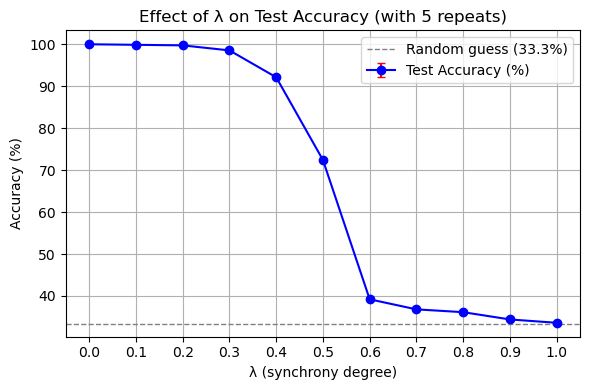

In [169]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ========== 参数 ==========
lambda_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # λ 值列表
repeats = 5  # 每个模型重复评估次数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== 测试函数 ==========
def test_accuracy_repeats_lambda(net, X_test, Y_test, repeats=5, batch_size=128):
    acc_list = []
    acc = test_accuracy(net, X_test, Y_test, batch_size=batch_size)
    acc_list.append(acc)
    return acc_list


# ========== 主测试逻辑 ==========
all_means = []
all_stds = []

for lam in lambda_values:
    model_path = f"coin_f{int(lam * 10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing for λ = {lam} ===")

    X_train, Y_train, X_val, Y_val, X_test, Y_test = get_split_by_lambda(lam)

    # 加载模型
    net = MultilayerSNN((X_test.shape[1], 100, 3),  # 假设隐藏层为200，类别数为3
                        [dict(tau=50*ms, w_init=(-0.5, 0.7)),
                         dict(tau=500*ms, spiking=False, w_init=(-0.01, 0.01))])
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()

    # 测试准确率
    acc_list = test_accuracy_repeats_lambda(net, X_test, Y_test, repeats=repeats)
    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)

    all_means.append(mean_acc)
    all_stds.append(std_acc)

    print(f"λ={lam:.1f}, Mean Acc={mean_acc:.2%}, Std={std_acc:.2%} (over {repeats} runs)")

# ========== 可视化准确率曲线 ==========
plt.figure(figsize=(6, 4))
means_pct = [m * 100 for m in all_means]
stds_pct  = [s * 100 for s in all_stds]

plt.errorbar(lambda_values, means_pct, yerr=stds_pct,
             fmt='-o', color='b', ecolor='r', capsize=3,
             label='Test Accuracy (%)')

plt.axhline(33.3, color='gray', linestyle='--', linewidth=1, label='Random guess (33.3%)')

plt.xlabel("λ (synchrony degree)")
plt.ylabel("Accuracy (%)")
plt.title(f"Effect of λ on Test Accuracy (with {repeats} repeats)")
plt.xticks(lambda_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Next do the exploration of SHD Dataset